In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

Torch:  1.0.0.dev20181207
Torchvision:  0.2.1
sklearn:  0.20.1
Python:  3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


In [3]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [6]:
PATH = '../../../../../data/DogBreeds/'

In [7]:
import os
print(os.listdir(PATH))

['submission2.csv', 'submission101fullTTA.csv', 'submission1.csv', 'train.zip', 'train', 'test.zip', 'test', 'models', 'submissionRN101.csv', 'submission101full.csv', 'labels.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'submission.csv', 'labels.csv']


In [8]:
#print(os.listdir(PATH+'test'))

In [9]:
labels = pd.read_csv(PATH+'labels.csv')
labels.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
labels['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
leonberg                          106
cairn                             106
beagle                            105
japanese_spaniel                  105
australian_terrier                102
miniature_pinscher                102
blenheim_spaniel                  102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
whippet                            95
norwegian_elkhound                 95
siberian_husky                     95
pug         

In [11]:
from zipfile import ZipFile
files = os.listdir(PATH)
if not 'train.zip' in files:
    !kaggle competitions download -c dog-breed-identification -p PATH
if not 'train' in files:    
    for file in files:
        with ZipFile(PATH+file, 'r') as zipF:
            zipF.extractall(path=PATH)
            print(file,': Done')
os.listdir(PATH)        

['submission2.csv',
 'submission101fullTTA.csv',
 'submission1.csv',
 'train.zip',
 'train',
 'test.zip',
 'test',
 'models',
 'submissionRN101.csv',
 'submission101full.csv',
 'labels.csv.zip',
 'sample_submission.csv.zip',
 'sample_submission.csv',
 'submission.csv',
 'labels.csv']

In [12]:
path_img = PATH + 'train'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../../../../../data/DogBreeds/train/c8c1b76b12acf31fbaef3b420099391e.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/1a8a76a7bcc83f2ec151c83753945ac0.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/9eb927fcd2caba4b3d0dfc193a1dfbb4.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/a669f4da695562c34d6498cf1bc92066.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/a6eb4c19bbe8efd5d4fc9ac41e0cba4b.jpg')]

In [13]:
# tfms = get_transforms(do_flip=True)
tfms = get_transforms()
data = ImageDataBunch.from_csv(PATH, folder='train',test='test',csv_labels='labels.csv', ds_tfms=tfms, size=299,suffix='.jpg', bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (8178 items)
[Category boston_bull, Category dingo, Category bluetick, Category golden_retriever, Category bedlington_terrier]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (8178 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 344, 400), Image (3, 500, 500), Image (3, 375, 500)]...
Path: ../../../../../data/DogBreeds;

Valid: LabelList
y: CategoryList (2044 items)
[Category siberian_husky, Category dingo, Category affenpinscher, Category scottish_deerhound, Category maltese_dog]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (2044 items)
[Image (3, 173, 360), Image (3, 333, 500), Image (3, 533, 500), Image (3, 333, 500), Image (3, 375, 500)]...
Path: ../../../../../data/DogBreeds;

Test: LabelList
y: CategoryList (10357 items)
[Category boston_bull, Category boston_bull, Category boston_bull, Category boston_bull, Category boston_bull]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (10357 items)
[

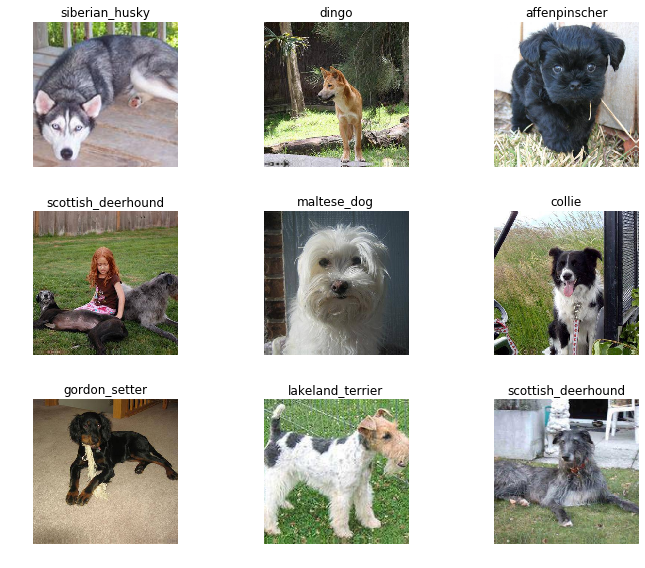

In [14]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

In [17]:
print(data.classes)
len(data.classes)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

120

In [18]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
#learn.interpret(tta=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/norvilr/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:10<00:00, 9661281.97it/s] 


In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [20]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,1.337702,0.619633,0.182485
2,1.049412,0.530616,0.186399
3,0.857867,0.421836,0.131115
4,0.704935,0.389373,0.117906
5,0.555228,0.343047,0.102740
6,0.399118,0.343063,0.103229


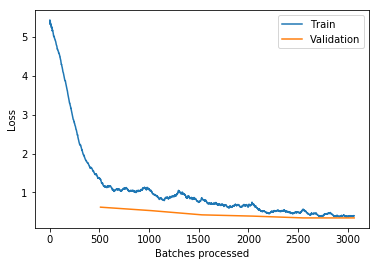

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-1')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

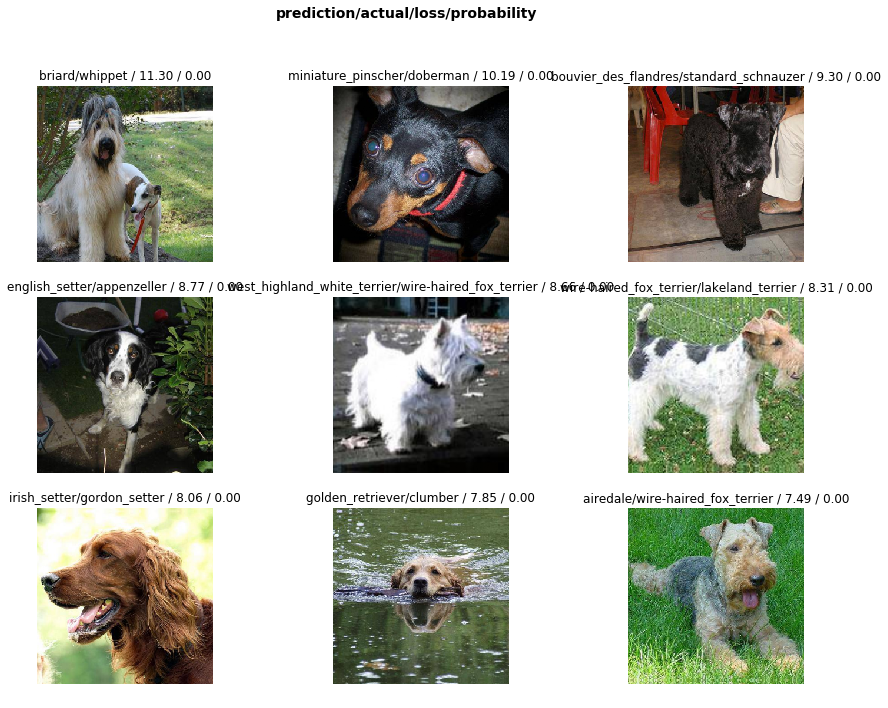

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

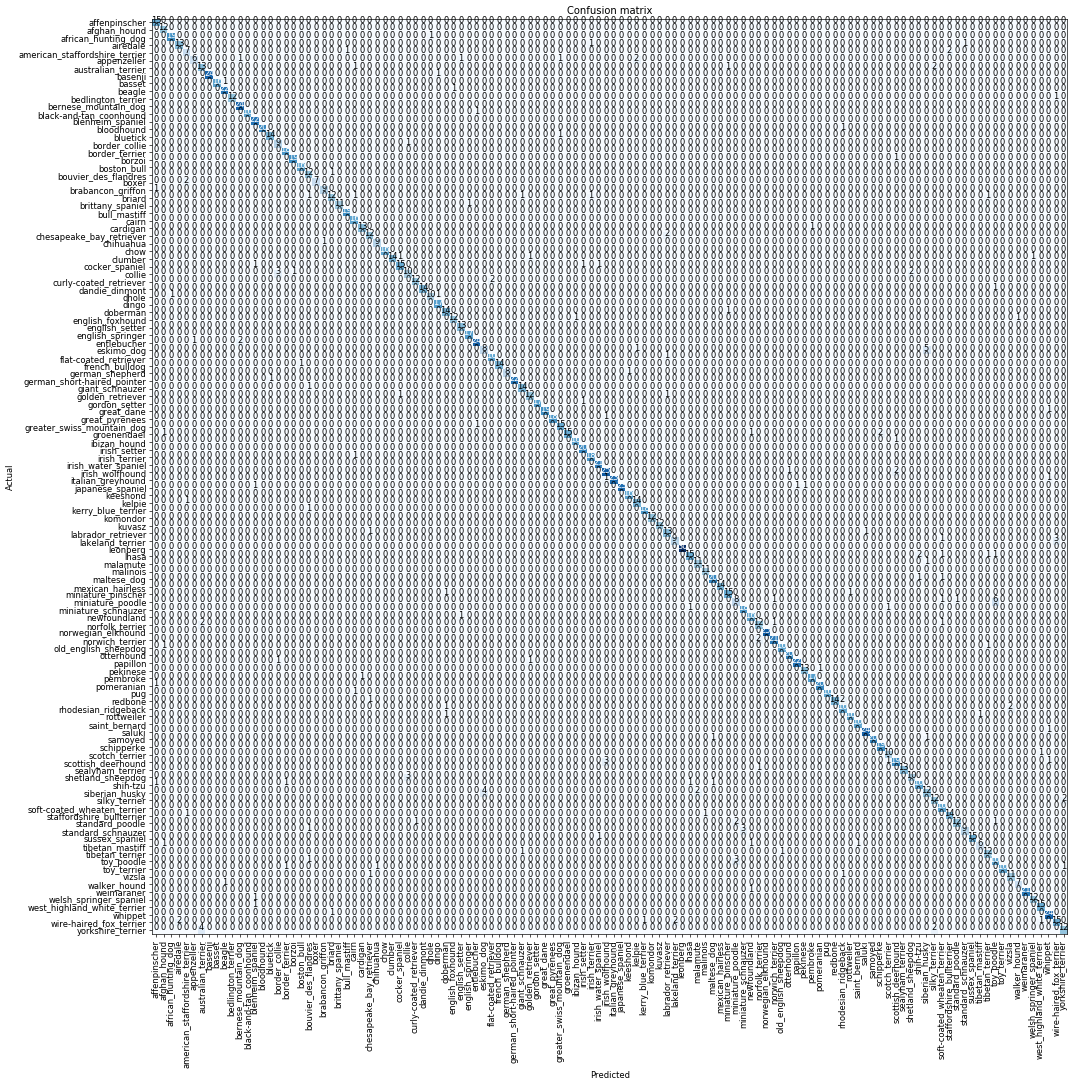

In [25]:
interp.plot_confusion_matrix(figsize=(18,18), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('miniature_poodle', 'toy_poodle', 6),
 ('eskimo_dog', 'siberian_husky', 5),
 ('siberian_husky', 'eskimo_dog', 4),
 ('yorkshire_terrier', 'australian_terrier', 4),
 ('collie', 'border_collie', 3),
 ('lakeland_terrier', 'wire-haired_fox_terrier', 3),
 ('scottish_deerhound', 'irish_wolfhound', 3),
 ('shetland_sheepdog', 'collie', 3),
 ('standard_schnauzer', 'miniature_schnauzer', 3),
 ('toy_poodle', 'miniature_poodle', 3)]

In [27]:
# Since our model is working as we expect it to, we will unfreeze our model and train some more.
learn.unfreeze()

In [36]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


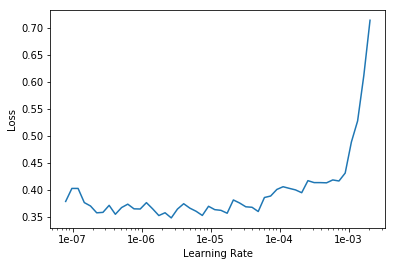

In [30]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.542502,0.454941,0.133562
2,0.543178,0.456327,0.138943
3,0.372267,0.409149,0.124266
4,0.247401,0.393358,0.119863


In [ ]:
learn.recorder.plot_losses()

In [ ]:
dogNr=9
data.test_ds[dogNr][0]

In [ ]:
b = learn.predict(data.test_ds[dogNr][0])
print(b[0])

In [ ]:
sample_submission_df = pd.read_csv(PATH+'sample_submission.csv')
sample_submission_df.head()

In [ ]:
log_preds, y = learn.TTA(ds_type=DatasetType.Test) # use test dataset rather than validation dataset

In [ ]:
df = pd.DataFrame(log_preds.numpy())
df.head()

In [ ]:
#list first few prediction classes
df.idxmax(axis=1).head()

In [ ]:
#get test file names
test_img = PATH + 'test'
tnames = get_image_files(test_img)
tnames[:5]


In [ ]:
test_files = os.listdir(PATH+'test')
print(test_files[:5])
len(test_files), type(test_files)

In [ ]:
data.test_ds.x

In [ ]:
#add class labels to data frame
df.columns = data.classes
df.head()

In [ ]:
#insert id by remvoing .jpg from file name
# test_files should also be saved in data.test_ds.x
df.insert(0, "id", [file[:-4] for file in test_files])
df.head()

In [ ]:
df.to_csv(PATH+"submission50tta.csv", index=False)
# Kaggle score 0.39257

## Trying predictions with raw get_preds instead of TTA

In [ ]:
# Get Predictions
predictions,y = learn.get_preds(ds_type=DatasetType.Test)


In [ ]:
df2 = pd.DataFrame(predictions.numpy())
df2.head()

In [ ]:
#add class labels to data frame
df2.columns = data.classes
df2.head()

In [ ]:
#insert id by remvoing .jpg from file name
df2.insert(0, "id", [file[:-4] for file in test_files])
df2.head()

In [ ]:
df2.to_csv(PATH+"submission50.csv", index=False)
# Kaggle score 0.35418

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(16, figsize=(15,11))